In [1]:
# Import all the important stuff
import numpy as np
from scipy.optimize import minimize
from astropy.io import fits

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
import matplotlib.image as mpimg

import emcee

# Personal python module for masks and profiles (available on github)
import gilphot as gp 

# MRF (Surface brightness contrast)
from mrf import sbcontrast

import timeit

In [2]:
# Defining all important galaxy-specific variables

gal = "3501"

pix_size = 2.5 # arcsec

ra, dec = 165.696949, 17.989337       # From NED
center_sub = (2000.0511, 1999.7489)   # from Imfit model (avg. of r and g)
PA = 28.5017                          # from Imfit model

zerop_g = 27.29465270776438 
zerop_r = 27.0039945325652

# Galactic extinction (Schlafly et al. 2011; accessed via NED)
extinct_g = 0.077
extinct_r = 0.053

# Mean distance tabulated by NED (mostly Tully-Fisher distances)
# Angular to distance scale form arcsec2parsec.joseonorbe.com
dist = 23.8 # Mpc
DM = 31.88
kpc_factor = 0.11477168296775592 # kpc/arcsec

## Loading images

In [3]:
# "_sub": source-subtracted images processed with MRF

fitsfile_sub = f"/home/cgilhuly/Workspace/MRF/NGC{gal}/Images/NGC{gal}-final-g.fits"
image_g_sub, header_g_sub = fits.getdata(fitsfile_sub, header=True)
print(np.shape(image_g_sub))

fitsfile_sub = f"/home/cgilhuly/Workspace/MRF/NGC{gal}/Images/NGC{gal}-final-r.fits"
image_r_sub = fits.getdata(fitsfile_sub)
print(np.shape(image_r_sub))

(4000, 4000)
(4000, 4000)


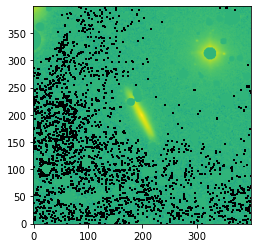

In [4]:
plt.imshow(np.log10(image_r_sub+5)[1800:2200, 1800:2200], origin="lower"); plt.show()

## Loading mask

"mask": default mask of MRF residuals, reduction artifacts, bright stars, other galaxies, cirrus, sources not deblended from central galaxy

"mask2": more aggressively masks bright stars and cirrus

In [5]:
maskfile = f"/home/cgilhuly/Workspace/MRF/NGC{gal}/Images/NGC{gal}-sourcesub-mask.fits"
maskfile_temp = f"/home/cgilhuly/Workspace/MRF/NGC{gal}/Images/NGC{gal}-sourcesub-mask_tweak.fits"
regions = f"/home/cgilhuly/Workspace/MRF/NGC{gal}/NGC{gal}_mask4.txt"
# If mask needs to be regenerated:
#mask = gp.make_source_mask( image_g_sub, image_r_sub, header_g_sub, regions, maskfile, expand = 0 )

mask, header_mask = fits.getdata(maskfile, header=True)
mask = gp.update_source_mask(mask, header_mask, regions, maskfile_temp) 
print( np.shape(mask) )

# If mask needs to be augmented for better limiting PA/ellip of 2D profile:
# regions = f"/home/cgilhuly/Workspace/MRF/NGC{gal}/NGC{gal}_asymm.txt"
# mask = gp.update_source_mask( mask, header_mask, extra_regions_0, maskfile )
# fits.writeto(...)

(4000, 4000)


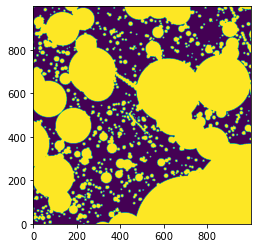

In [6]:
plt.imshow(mask[1500:2500, 1500:2500], origin="lower"); plt.show()

In [7]:
maskfile2 = f"/home/cgilhuly/Workspace/MRF/NGC{gal}/Images/NGC{gal}-sourcesub-mask2.fits"
regions2 = f"/home/cgilhuly/Workspace/MRF/NGC{gal}/NGC{gal}_mask2_new.txt"

#mask2 = gp.update_source_mask(mask, header_g_sub, regions2, maskfile2)
mask2 = fits.getdata(maskfile2)

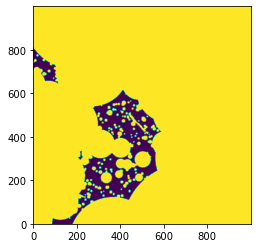

In [8]:
plt.imshow(mask2[1500:2500, 1500:2500], origin="lower"); plt.show()

## Minor axis wedge profiles

Wedge + source mask for wedge 0:


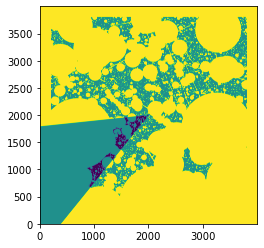

Wedge + source mask for wedge 1:


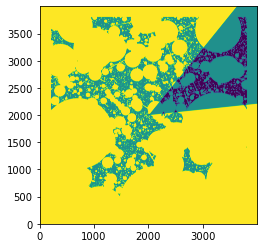

Measuring sky for wedge 0 ...


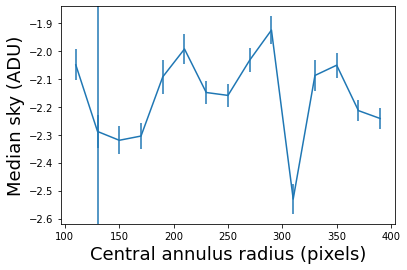

Measuring sky for wedge 1 ...


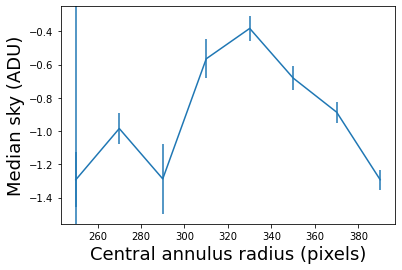

Wedge + source mask for wedge 0:


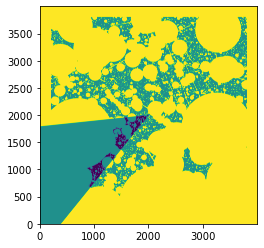

Wedge + source mask for wedge 1:


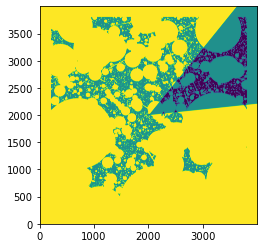

Measuring sky for wedge 0 ...


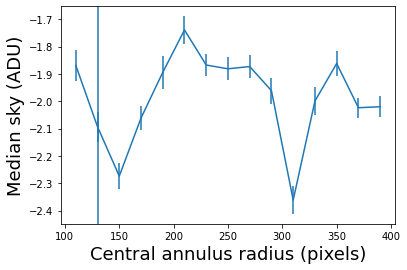

Measuring sky for wedge 1 ...


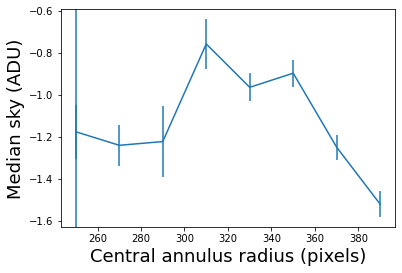

In [9]:
# Position angle of minor axis (in S of W) relative to Imfit major axis "PA" (W of N)
PA_ = ((180-PA)%360)*np.pi/180.

wedge_r = gp.WedgeProfiles(image_r_sub, mask, center_sub, PA_)
wedge_r.measure_sky(image_r_sub, 100, 400, bin_width=20, baseline=3, method="thresh_slope", thresh=5e-3)

wedge_g = gp.WedgeProfiles(image_g_sub, mask, center_sub, PA_)
wedge_g.measure_sky(image_g_sub, 100, 400, bin_width=20, baseline=3, method="thresh_slope", thresh=5e-3)


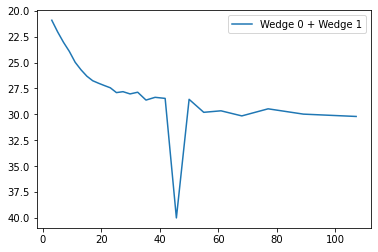

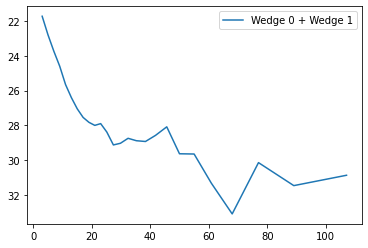

In [10]:
rad_r, SB_r, err_SB_r_p, err_SB_r_m, err_SB_r_ps, err_SB_r_ms = wedge_r.get_single_profile(image_r_sub, 
                                                                                           zerop_r,
                                                                                           r_min=2, 
                                                                                           r_max=100, 
                                                                                           step=5, 
                                                                                           scale="log")

rad_g, SB_g, err_SB_g_p, err_SB_g_m, err_SB_g_ps, err_SB_g_ms = wedge_g.get_single_profile(image_g_sub, 
                                                                                           zerop_g,
                                                                                           r_min=2, 
                                                                                           r_max=100, 
                                                                                           step=5, 
                                                                                           scale="log")

# Converting upper and lower bounds into offsets for use with plt.errorbar()
err_all_tmp = [SB_r - err_SB_r_p, err_SB_r_m - SB_r]
SB_err_r = np.array(err_all_tmp)

err_all_tmp = [SB_g - err_SB_g_p, err_SB_g_m - SB_g]
SB_err_g = np.array(err_all_tmp)

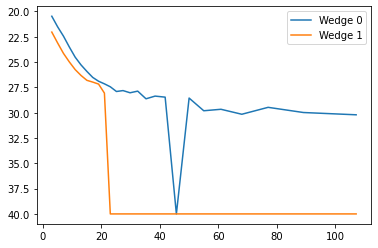

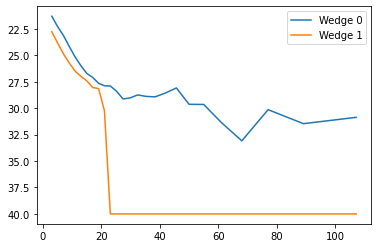

In [11]:
# Individual wedge profiles for quick comparison (not unpacking all error values)
rad_rW, SB_rW, err_SB_r_pW, err_SB_r_mW, _, _ = wedge_r.get_wedge_profiles(image_r_sub, 
                                                                           zerop_r,
                                                                           r_min=2, 
                                                                           r_max=100, 
                                                                           step=5, 
                                                                           scale="log")

rad_gW, SB_gW, err_SB_g_pW, err_SB_g_mW, _, _ = wedge_g.get_wedge_profiles(image_g_sub, 
                                                                           zerop_g,
                                                                           r_min=2, 
                                                                           r_max=100, 
                                                                           step=5, 
                                                                           scale="log")

err_all_tmp = [SB_rW[0] - err_SB_r_pW[0], err_SB_r_mW[0] - SB_rW[0]]
SB_err_rW0 = np.array(err_all_tmp)

err_all_tmp = [SB_rW[1] - err_SB_r_pW[1], err_SB_r_mW[1] - SB_rW[1]]
SB_err_rW1 = np.array(err_all_tmp)

err_all_tmp = [SB_gW[0] - err_SB_g_pW[0], err_SB_g_mW[0] - SB_gW[0]]
SB_err_gW0 = np.array(err_all_tmp)

err_all_tmp = [SB_gW[1] - err_SB_g_pW[1], err_SB_g_mW[1] - SB_gW[1]]
SB_err_gW1 = np.array(err_all_tmp)

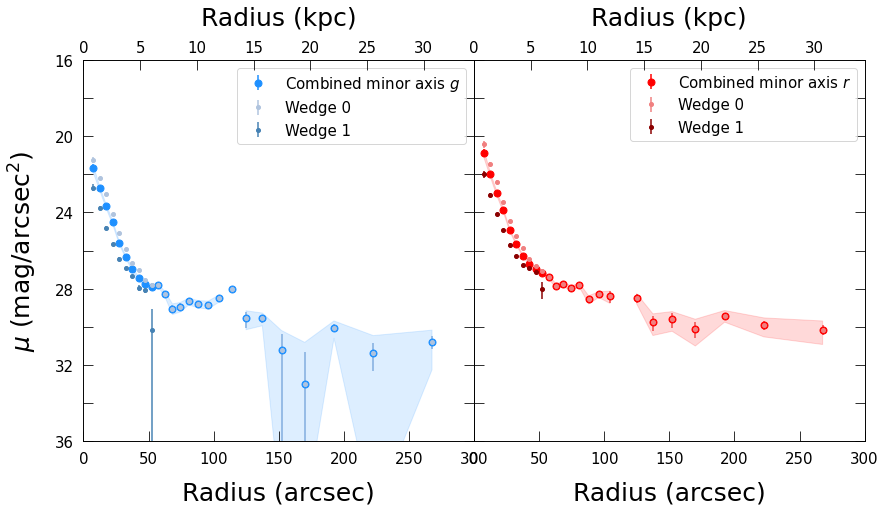

In [12]:
# Plot comparing individual wedge profiles with combined profile
# Not yet corrected for scattered light

fig, ax = plt.subplots(ncols=2)
plt.subplots_adjust(wspace=0)
ax_r = ax[1]
ax_g = ax[0]
radii = rad_r*pix_size

max_radius = 300 # arcsec

# Combined profiles
ax_r.errorbar(radii, SB_r - extinct_r, yerr=SB_err_r, fmt='o', c="r", label="Combined minor axis $r$", markersize=7)
ax_g.errorbar(radii, SB_g - extinct_g, yerr=SB_err_g, fmt='o', c="dodgerblue", label="Combined minor axis $g$", markersize=7)

# Individual wedges
ax_r.errorbar(radii, SB_rW[0] - extinct_r, yerr=SB_err_rW0, fmt='o', c="lightcoral", label="Wedge 0", markersize=4)
ax_r.errorbar(radii, SB_rW[1] - extinct_r, yerr=SB_err_rW1, fmt='o', c="darkred", label="Wedge 1", markersize=4)
ax_g.errorbar(radii, SB_gW[0] - extinct_g, yerr=SB_err_gW0, fmt='o', c="lightsteelblue", label="Wedge 0", markersize=4)
ax_g.errorbar(radii, SB_gW[1] - extinct_g, yerr=SB_err_gW1, fmt='o', c="steelblue", label="Wedge 1", markersize=4)

# Error envelopes only for combined profiles
ax_r.fill_between(radii, err_SB_r_ps - extinct_r, err_SB_r_ms - extinct_r, alpha=0.15, color="r")
ax_g.fill_between(radii, err_SB_g_ps - extinct_g, err_SB_g_ms - extinct_g, alpha=0.15, color="dodgerblue")

for a in ax:
    
    a.invert_yaxis()

    a.legend(prop={'size': 15})
    a.set_xlabel(r"Radius (arcsec)", size=25, labelpad=15)
    a.tick_params(labelsize=15)
    
    a.xaxis.set_tick_params(which='major',size=10,pad=10,top=True,right=True)
    a.yaxis.set_tick_params(which='major',size=10,pad=10,top=True,right=True)
    a.tick_params(axis='both',which='major',direction='in')
    
    a.set_xlim(0, max_radius)
    a.set_ylim(36, 16)

    a.set_yticks([16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36])

    
    # Secondary x axis for physical length scales
    ax3 = a.twiny()
    ax3.set_xlim(0,kpc_factor*max_radius) 
    ax3.set_xlabel(r"Radius (kpc)", size=25, labelpad=15)
    ax3.tick_params(labelsize=15)
    ax3.xaxis.set_tick_params(which='major',size=10,pad=5,top=True,right=True, direction="in")

ax_g.set_ylabel(r"$\mu$ (mag/arcsec$^2$)", size=25, labelpad=15)
ax_g.set_yticklabels(["16", "", "20", "", "24", "", "28", "", "32", "", "36"])
ax_r.set_yticklabels([])

fig.set_size_inches(14, 7)
plt.show()

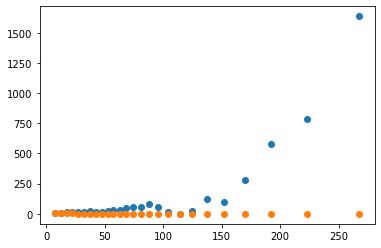

In [13]:
plt.scatter(radii, wedge_g.n_pixels[0])
plt.scatter(radii, np.log10(wedge_g.flux[0]))

## 2D modelling with Imfit

Procedure to follow outside of this notebook:
- Work with non source-subtracted cutout (sky counts important for sigma image)
- Pass gain, ncombine, and rdnoise estimates as arguments when fitting
- Start simple and add more (or more complicated) components
- Re-run final model on source-subtracted cutout (fit small pixel shift first)
- Fit on a small region but then produce final models with full cutout (to enable apples-to-apples profile extraction and comparisons)

To generate model images at full size:

../makeimage --output NGC4307_model_r_PSF.fits --refimage ../../MRF/NGC4307/Images/NGC4307-final-r.fits [--psf NGC_4307_psf_r.fits] bestfit_parameters_imfit_final_r.dat

../makeimage --output NGC4307_model_g_PSF.fits --refimage ../../MRF/NGC4307/Images/NGC4307-final-g.fits [--psf NGC_4307_psf_g.fits] bestfit_parameters_imfit_final_g.dat

In [14]:
# Load in model images
fitsfile_model = f"/home/cgilhuly/Workspace/Imfit/NGC{gal}/NGC{gal}_model_r_PSF.fits"
image_r_model_PSF = fits.getdata(fitsfile_model, header=False)
print(np.shape(image_r_model_PSF))

fitsfile_model = f"/home/cgilhuly/Workspace/Imfit/NGC{gal}/NGC{gal}_model_r_noPSF.fits"
image_r_model_noPSF = fits.getdata(fitsfile_model, header=False)
print(np.shape(image_r_model_noPSF))

fitsfile_model = f"/home/cgilhuly/Workspace/Imfit/NGC{gal}/NGC{gal}_model_g_PSF.fits"
image_g_model_PSF = fits.getdata(fitsfile_model, header=False)
print(np.shape(image_g_model_PSF))

fitsfile_model = f"/home/cgilhuly/Workspace/Imfit/NGC{gal}/NGC{gal}_model_g_noPSF.fits"
image_g_model_noPSF = fits.getdata(fitsfile_model, header=False)
print(np.shape(image_g_model_noPSF))

mask_model = np.zeros(np.shape(image_r_model_PSF))

(4000, 4000)
(4000, 4000)
(4000, 4000)
(4000, 4000)


### Comparison with 2D model (with and without PSF)

Imposing previously fitted r-band isophotes on model images for an apples-to-apples comparison

Wedge + source mask for wedge 0:


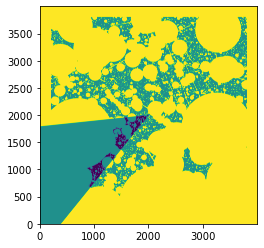

Wedge + source mask for wedge 1:


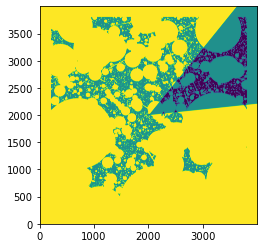

Wedge + source mask for wedge 0:


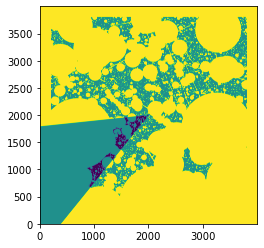

Wedge + source mask for wedge 1:


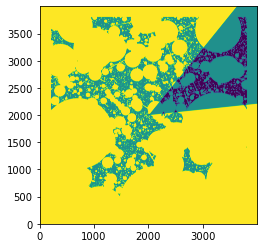

Wedge + source mask for wedge 0:


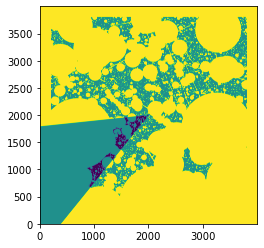

Wedge + source mask for wedge 1:


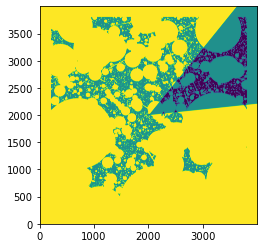

Wedge + source mask for wedge 0:


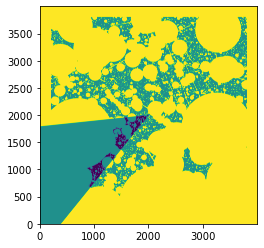

Wedge + source mask for wedge 1:


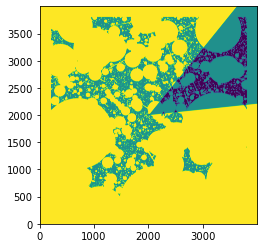

In [15]:
model_r_PSF = gp.WedgeProfiles(image_r_model_PSF, mask, center_sub, PA_)
model_rad_r, model_flux_r_PSF, model_err_flux_r_PSF, model_syserr_flux_r_PSF = model_r_PSF.get_single_profile(
                                                                                    image_r_model_PSF, 
                                                                                    0, 
                                                                                    r_min=2, 
                                                                                    r_max=100, 
                                                                                    step=5, 
                                                                                    scale="log", 
                                                                                    output="linear")

model_r_noPSF = gp.WedgeProfiles(image_r_model_noPSF, mask, center_sub, PA_)
model_rad_r, model_flux_r_noPSF, model_err_flux_r_noPSF, model_syserr_flux_r_noPSF = model_r_noPSF.get_single_profile(
                                                                                        image_r_model_noPSF, 
                                                                                        0, 
                                                                                        r_min=2, 
                                                                                        r_max=100, 
                                                                                        step=5, 
                                                                                        scale="log", 
                                                                                        output="linear")
model_g_PSF = gp.WedgeProfiles(image_g_model_PSF, mask, center_sub, PA_)
model_rad_g, model_flux_g_PSF, model_err_flux_g_PSF, model_syserr_flux_g_PSF = model_g_PSF.get_single_profile(
                                                                                    image_g_model_PSF, 
                                                                                    0, 
                                                                                    r_min=2, 
                                                                                    r_max=100, 
                                                                                    step=5, 
                                                                                    scale="log", 
                                                                                    output="linear")
model_g_noPSF = gp.WedgeProfiles(image_g_model_noPSF, mask, center_sub, PA_)
model_rad_g, model_flux_g_noPSF, model_err_flux_g_noPSF, model_syserr_flux_g_noPSF = model_g_noPSF.get_single_profile(
                                                                                        image_g_model_noPSF, 
                                                                                        0, 
                                                                                        r_min=2, 
                                                                                        r_max=100, 
                                                                                        step=5, 
                                                                                        scale="log", 
                                                                                        output="linear")

In [16]:
# Loading PSF fitting results for comparison
from elderflower.sampler import Sampler
from elderflower.utils import make_psf_from_fit

psf_file_r = "/home/cgilhuly/Workspace/Elderflower/BatchJobs/NGC_" + gal + "-central2-1500pix-R-fit3p.res"

temp_sampler_R = Sampler.load_results(psf_file_r)        
psf_r, params = make_psf_from_fit(temp_sampler_R)
del temp_sampler_R


psf_file_g = "/home/cgilhuly/Workspace/Elderflower/BatchJobs/NGC_" + gal + "-central2-1500pix-G-fit3p.res"

temp_sampler_G = Sampler.load_results(psf_file_g)        
psf_g, params = make_psf_from_fit(temp_sampler_G)
del temp_sampler_G

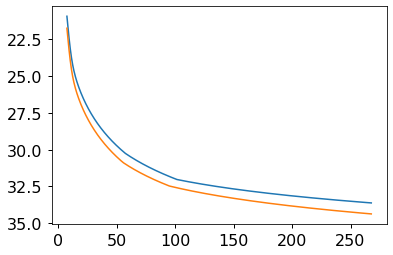

In [17]:
# Turning PSF fitting results into a surface brightness profile

rad_psf = np.linspace(min(radii/pix_size),max(radii/pix_size),1000)
flux_psf_r = (1-psf_r.frac)*psf_r.f_core1D(rad_psf) + psf_r.frac*psf_r.f_aureole1D(rad_psf)
mags_psf_r = gp.flux_to_mags(flux_psf_r, 0, zerop_r)
r_shift = mags_psf_r[0] - SB_r[0]
mags_psf_r = mags_psf_r - r_shift


flux_psf_g = (1-psf_g.frac)*psf_g.f_core1D(rad_psf) + psf_g.frac*psf_g.f_aureole1D(rad_psf)
mags_psf_g = gp.flux_to_mags(flux_psf_g, 0, zerop_g)
g_shift = mags_psf_g[0] - SB_g[0]
mags_psf_g = mags_psf_g -g_shift

# Quick plot for a sanity check
plt.plot(rad_psf*pix_size, mags_psf_r)
plt.plot(rad_psf*pix_size, mags_psf_g)

plt.gca().invert_yaxis()

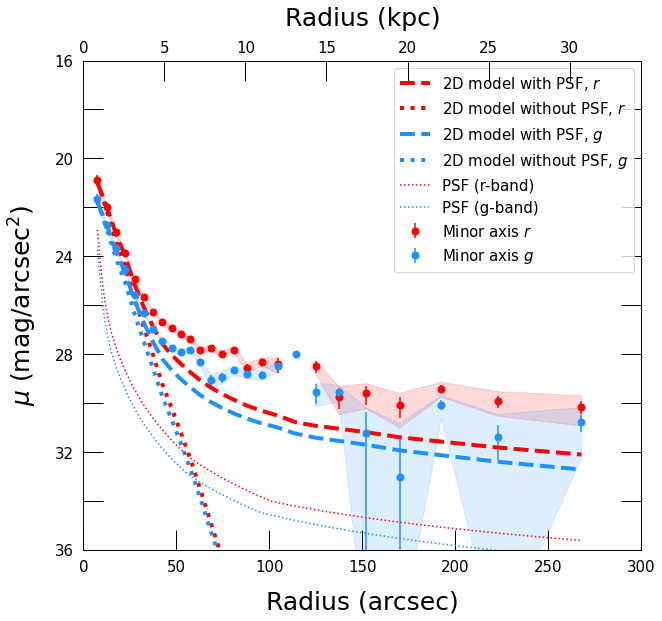

In [18]:
# Plotting comparison of model profiles (and PSF) with observed profiles

fig, ax = plt.subplots()
radii = np.array(rad_r)*pix_size

# Observed
ax.errorbar(radii, SB_r - extinct_r, yerr=SB_err_r, fmt='o', c="r", label="Minor axis $r$", markersize=7)
ax.errorbar(radii, SB_g - extinct_g, yerr=SB_err_g, fmt='o', c="dodgerblue", label="Minor axis $g$", markersize=7)
ax.fill_between(radii, err_SB_r_ps - extinct_r, err_SB_r_ms - extinct_r, alpha=0.15, color="r")
ax.fill_between(radii, err_SB_g_ps - extinct_g, err_SB_g_ms - extinct_g, alpha=0.15, color="dodgerblue")

# Models
plt.plot(radii, gp.flux_to_mags(model_flux_r_PSF, 0.0, zerop_r), "r--", lw=4, label="2D model with PSF, $r$")
plt.plot(radii, gp.flux_to_mags(model_flux_r_noPSF, 0.0, zerop_r), "r:", lw=4, label="2D model without PSF, $r$")

plt.plot(radii, gp.flux_to_mags(model_flux_g_PSF, 0.0, zerop_g), "--", c="dodgerblue", lw=4, label="2D model with PSF, $g$")
plt.plot(radii, gp.flux_to_mags(model_flux_g_noPSF, 0.0, zerop_g), ":", c="dodgerblue", lw=4, label="2D model without PSF, $g$")


# PSFs for each band
plt.plot(rad_psf*pix_size, mags_psf_r + 2, 'r:', label="PSF (r-band)")
plt.plot(rad_psf*pix_size, mags_psf_g + 2, ':', c="dodgerblue", label="PSF (g-band)")


plt.gca().invert_yaxis()

plt.legend(prop={'size': 15})

ax.set_ylabel(r"$\mu$ (mag/arcsec$^2$)", size=25, labelpad=15)
ax.set_xlabel(r"Radius (arcsec)", size=25, labelpad=15)
ax.tick_params(labelsize=15)
ax.invert_yaxis()

ax.xaxis.set_tick_params(which='major',size=20,pad=10,top=True,right=True)
ax.yaxis.set_tick_params(which='major',size=20,pad=10,top=True,right=True)
ax.tick_params(axis='both',which='major',direction='in')

# Secondary x axis for physical length scales
ax3 = ax.twiny()
ax3.set_xlim(0,kpc_factor*300) 
ax3.set_xlabel(r"Radius (kpc)", size=25, labelpad=15)
ax3.tick_params(labelsize=15)
ax3.xaxis.set_tick_params(which='major',size=20,pad=5,top=True,right=True, direction="in")

ax.set_xlim(0, 300)
ax.set_ylim(36, 16)

ax.set_yticks([16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36])
ax.set_yticklabels(["16", "", "20", "", "24", "", "28", "", "32", "", "36"])

fig.set_size_inches(10,9)
plt.show()

## Subtracting (estimated) scattered disk light

The purpose of generating model images with and without PSF convolution is to approximate the light from the bright inner parts of the galaxy. The model image without PSF convolution approximates the true distribution of galaxy light and the model image with PSF convolution shows how this light distribution changes due to scattered light. The relative difference between the two models is small where the galaxy is bright and becomes larger in the faint outer regions.

We attempt to counteract the effect of scattered light by subtracting the model difference profile (PSF_profile - noPSF_profile) from the observed surface brightness profile. The goal is to remove light scattered from the bright inner regions of the galaxy, which otherwise is a significant fraction of the light observed at large radii. This will also have the effect of slightly increasing the observed profile at small radii. 

In [19]:
model_flux_r_scattered = model_flux_r_PSF - model_flux_r_noPSF
model_flux_g_scattered = model_flux_g_PSF - model_flux_g_noPSF

In [20]:
# Calculating scattered light-"corr"ected surface brightness profiles and associated errors
# Also correcting for extinction

# Grabbing observed profiles in flux units
rad_r, flux_r, err_flux_r, syserr_flux_r, = wedge_r.get_single_profile(image_r_sub, 
                                                                       zerop_r,
                                                                       r_min=2, 
                                                                       r_max=100, 
                                                                       step=5, 
                                                                       scale="log",
                                                                       output="linear")

rad_g, flux_g, err_flux_g, syserr_flux_g, = wedge_g.get_single_profile(image_g_sub, 
                                                                       zerop_g,
                                                                       r_min=2, 
                                                                       r_max=100, 
                                                                       step=5, 
                                                                       scale="log",
                                                                       output="linear")

SB_r_corr = gp.flux_to_mags(flux_r - model_flux_r_scattered, 0, zerop_r) - extinct_r
SB_g_corr = gp.flux_to_mags(flux_g - model_flux_g_scattered, 0, zerop_g) - extinct_g

# Error in terms of flux
flux_r_corr_err = np.sqrt(err_flux_r**2 + model_err_flux_r_PSF**2 + model_err_flux_r_noPSF**2)
flux_g_corr_err = np.sqrt(err_flux_g**2 + model_err_flux_g_PSF**2 + model_err_flux_g_noPSF**2)

flux_r_corr_syserr = np.sqrt(syserr_flux_r**2 + model_syserr_flux_r_PSF**2 + model_syserr_flux_r_noPSF**2)
flux_g_corr_syserr = np.sqrt(syserr_flux_g**2 + model_syserr_flux_g_PSF**2 + model_syserr_flux_g_noPSF**2)

# Calculating upper and lower SB limits based on flux error
SB_r_corr_err_p = gp.flux_to_mags(flux_r - model_flux_r_scattered + flux_r_corr_err, 0, zerop_r, default=40)
SB_r_corr_err_m = gp.flux_to_mags(flux_r - model_flux_r_scattered - flux_r_corr_err, 0, zerop_r, default=40)

SB_g_corr_err_p = gp.flux_to_mags(flux_g - model_flux_g_scattered + flux_g_corr_err, 0, zerop_g, default=40)
SB_g_corr_err_m = gp.flux_to_mags(flux_g - model_flux_g_scattered - flux_g_corr_err, 0, zerop_g, default=40)

SB_r_corr_err_ps = gp.flux_to_mags(flux_r  - model_flux_r_scattered + flux_r_corr_syserr, 0, zerop_r, default=40)
SB_r_corr_err_ms = gp.flux_to_mags(flux_r  - model_flux_r_scattered - flux_r_corr_syserr, 0, zerop_r, default=40)

SB_g_corr_err_ps = gp.flux_to_mags(flux_g - model_flux_g_scattered + flux_g_corr_syserr, 0, zerop_g, default=40)
SB_g_corr_err_ms = gp.flux_to_mags(flux_g - model_flux_g_scattered - flux_g_corr_syserr, 0, zerop_g, default=40)

# Combining upper and lower limits into arrays for plt.errorbar() 
err_all_tmp = [SB_r_corr - SB_r_corr_err_p, SB_r_corr_err_m - SB_r_corr]
SB_err_r_corr = np.array(err_all_tmp)

err_all_tmp = [SB_g_corr - SB_g_corr_err_p, SB_g_corr_err_m - SB_g_corr]
SB_err_g_corr = np.array(err_all_tmp)

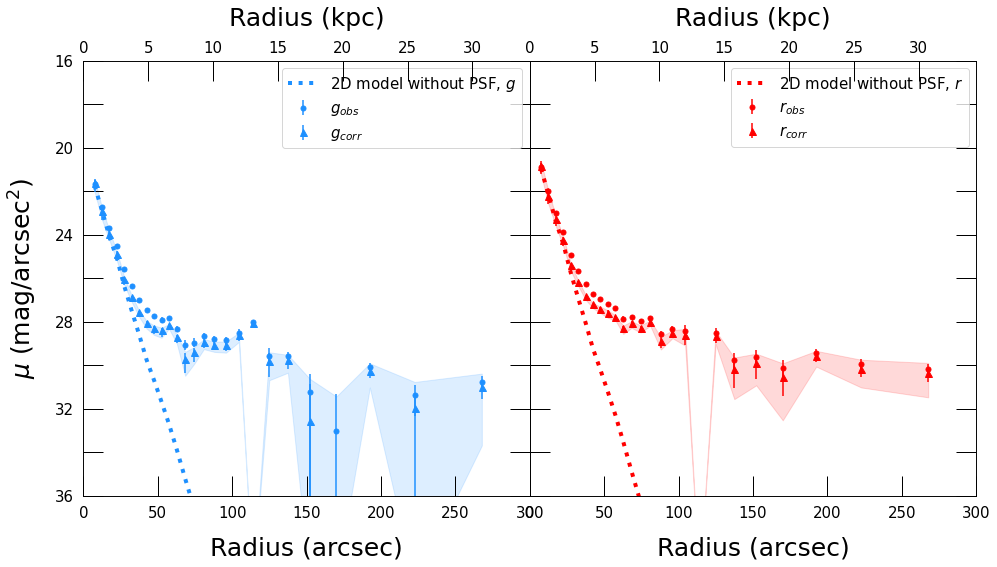

In [21]:
# Plotting comparison of surface brightness profiles before and after scattered light correction

fig, ax = plt.subplots(ncols=2)
plt.subplots_adjust(wspace=0)
ax_r = ax[1]
ax_g = ax[0]

# Combined profiles
ax_r.errorbar(radii, SB_r - extinct_r, yerr=SB_err_r, fmt='o', c="r", label="$r_{obs}$", markersize=5)
ax_g.errorbar(radii, SB_g - extinct_g, yerr=SB_err_g, fmt='o', c="dodgerblue", label="$g_{obs}$", markersize=5)

# Individual wedges
#ax_r.errorbar(radii, SB_rW[0] - extinct_r, yerr=SB_err_rW0, fmt='o', c="lightcoral", label="Wedge 0", markersize=4)
#ax_r.errorbar(radii, SB_rW[1] - extinct_r, yerr=SB_err_rW1, fmt='o', c="darkred", label="Wedge 1", markersize=4)
#ax_g.errorbar(radii, SB_gW[0] - extinct_g, yerr=SB_err_gW0, fmt='o', c="lightsteelblue", label="Wedge 0", markersize=4)
#ax_g.errorbar(radii, SB_gW[1] - extinct_g, yerr=SB_err_gW1, fmt='o', c="steelblue", label="Wedge 1", markersize=4)

# Corrected profiles
ax_r.errorbar(radii, SB_r_corr, yerr=SB_err_r_corr, fmt='o', marker='^', color='r', label="$r_{corr}$", markersize=7)
ax_g.errorbar(radii, SB_g_corr, yerr=SB_err_g_corr, fmt='o', marker='^', color='dodgerblue', label="$g_{corr}$", markersize=7)

# Error envelopes only for combined profiles
ax_r.fill_between(radii, SB_r_corr_err_ps, SB_r_corr_err_ms, alpha=0.15, color="r")
ax_g.fill_between(radii, SB_g_corr_err_ps, SB_g_corr_err_ms, alpha=0.15, color="dodgerblue")

# Models
ax_r.plot(radii, gp.flux_to_mags(model_flux_r_noPSF, 0.0, zerop_r), "r:", lw=4, label="2D model without PSF, $r$")
ax_g.plot(radii, gp.flux_to_mags(model_flux_g_noPSF, 0.0, zerop_g), ":", c="dodgerblue", lw=4, label="2D model without PSF, $g$")


for a in ax:
    
    a.invert_yaxis()

    a.legend(prop={'size': 15})


    a.set_xlabel(r"Radius (arcsec)", size=25, labelpad=15)
    a.tick_params(labelsize=15)
    a.invert_yaxis()

    a.xaxis.set_tick_params(which='major',size=20,pad=10,top=True,right=True)
    a.yaxis.set_tick_params(which='major',size=20,pad=10,top=True,right=True)
    a.tick_params(axis='both',which='major',direction='in')

    # Secondary x axis for physical length scales
    ax3 = a.twiny()
    ax3.set_xlim(0,kpc_factor*300) 
    ax3.set_xlabel(r"Radius (kpc)", size=25, labelpad=15)
    ax3.tick_params(labelsize=15)
    ax3.xaxis.set_tick_params(which='major',size=20,pad=5,top=True,right=True, direction="in")

    a.set_xlim(0, 300)
    a.set_ylim(36, 16)

    a.set_yticks([16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36])

ax_g.set_ylabel(r"$\mu$ (mag/arcsec$^2$)", size=25, labelpad=15)
ax_g.set_yticklabels(["16", "", "20", "", "24", "", "28", "", "32", "", "36"])
ax_r.set_yticklabels([])

fig.set_size_inches(16,8)
plt.show()

In [22]:
# Scattered light corrected colour profile and error (without and with sys. uncertainty in sky)

gmr_corr = SB_g_corr - SB_r_corr

gmr_corr_err = gp.calc_colour_error(flux_g - model_flux_g_scattered, 
                                    flux_g_corr_err, 
                                    flux_r - model_flux_r_scattered, 
                                    flux_r_corr_err, 
                                    0, 
                                    0, 
                                    0, 
                                    0)

gmr_corr_err_sys =  gp.calc_colour_error(flux_g - model_flux_g_scattered, 
                                         flux_g_corr_syserr, 
                                         flux_r - model_flux_r_scattered, 
                                         flux_r_corr_syserr, 
                                         0, 
                                         0, 
                                         0, 
                                         0)


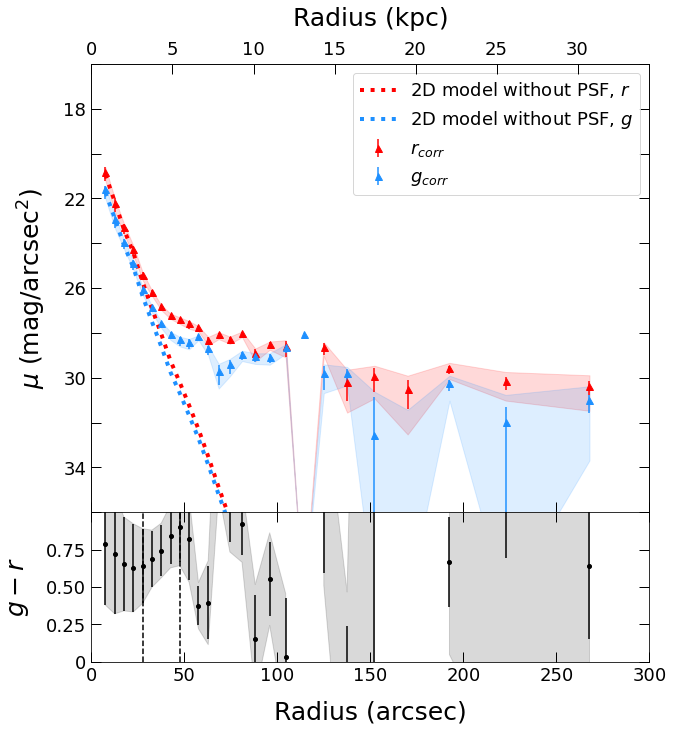

In [23]:
# Plotting corrected surface brightness and colour profiles together

colour_avg_range_corr = [30,50]  # in arcsec

# Converting radius range to index range
range_index_corr = [min(range(len(radii)), key=lambda x: abs(radii[x]-colour_avg_range_corr[0])), 
                   min(range(len(radii)), key=lambda x: abs(radii[x]-colour_avg_range_corr[1]))]


fig, ax = plt.subplots(ncols=1, nrows=2)
gs1 = gridspec.GridSpec(2,1,wspace=0,hspace=0, height_ratios = [3,1])

################################################################################
# Surface brightness profiles
ax0 = plt.subplot(gs1[0])

# Corrected profiles
ax0.errorbar(radii, SB_r_corr, yerr=SB_err_r_corr, fmt='o', marker='^', color='r', label="$r_{corr}$", markersize=7)
ax0.errorbar(radii, SB_g_corr, yerr=SB_err_g_corr, fmt='o', marker='^', color='dodgerblue', label="$g_{corr}$", markersize=7)

ax0.fill_between(radii, SB_r_corr_err_ps, SB_r_corr_err_ms, alpha=0.15, color="r")
ax0.fill_between(radii, SB_g_corr_err_ps, SB_g_corr_err_ms, alpha=0.15, color="dodgerblue")

# Models
ax0.plot(radii, gp.flux_to_mags(model_flux_r_noPSF, 0.0, zerop_r), "r:", lw=4, label="2D model without PSF, $r$")
ax0.plot(radii, gp.flux_to_mags(model_flux_g_noPSF, 0.0, zerop_g), ":", c="dodgerblue", lw=4, label="2D model without PSF, $g$")


leg = plt.legend(prop={'size': 18})

ax0.set_ylabel(r"$\mu$ (mag/arcsec$^2$)", size=25, labelpad=15)
ax0.xaxis.set_tick_params(which='major',size=10,pad=5,right=True, direction="in")

# Secondary x axis for physical length scales
ax00 = ax0.twiny()
ax00.set_xlim(0,kpc_factor*300) 
ax00.set_xlabel(r"Radius (kpc)", size=25, labelpad=15)
ax00.xaxis.set_tick_params(which='major',size=10,pad=5,top=True, bottom=False, direction="in")

ax0.set_xlim(0, 300)
ax0.set_xticklabels([])

ax0.set_ylim(36, 16)
ax0.set_yticks([16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36])
ax0.set_yticklabels(["", "18", "", "22", "", "26", "", "30", "", "34", "" ])

################################################################################
# g-r colour profiles
ax1 = plt.subplot(gs1[1])

ax1.errorbar(radii, gmr_corr, yerr=gmr_corr_err, fmt='o', label=r"$g-r$", color='k', markersize=4)
ax1.fill_between(radii, gmr_corr + gmr_corr_err_sys, gmr_corr - gmr_corr_err_sys, alpha=0.15, color="k")

# Radial range where fixed outer colour is determined
ax1.axvline(x=radii[range_index_corr[0]], c='k', ls='--')
ax1.axvline(x=radii[range_index_corr[1]], c='k', ls='--')

ax1.set_ylabel(r"$g-r$", size=25, labelpad=15)
ax1.set_xlabel(r"Radius (arcsec)", size=25, labelpad=15)

ax1.set_ylim(0,1)
ax1.set_yticks([0.0 ,0.25, 0.5, 0.75, 1.0])
ax1.set_yticklabels(["0", "0.25", "0.50", "0.75", ""])

ax1.xaxis.set_tick_params(which='major',size=10,pad=5,top=True,right=True, direction="in")

ax1.set_xlim(0,300)

################################################################################
for a in [ax0, ax1, ax00]:
    
    a.yaxis.set_tick_params(which='major',size=10,pad=5,top=True,right=True, direction="in")
    a.tick_params(labelsize=18)

fig.set_size_inches(10, 11)
plt.show()

## Surface stellar mass density profiles

Using colour-mass-to-light-ratio (CMLR) relations, a colour profile and an accompanying surface brightness profile can be used to calculate a surface stellar mass density profile. We adopt the (g-r, g) CMLR from Roediger & Courteau (2015): $\textrm{log}(\mathscr{M}_*/L)_g = 2.029(g-r) - 0.984$

Here's the math behind the calculations below:

-----

$\textrm{log}(\Sigma_*) = \textrm{log}\Big((\mathscr{M}_*/L) \times L \times (1/\Omega)^2\Big)$

$\textrm{log}(\Sigma_*) = \textrm{log}(\mathscr{M}_*/L)_g + 0.4(M_{g,\odot} - M_g) + \textrm{log}(1/\Omega)^2$

$\textrm{log}(\Sigma_*) = 2.029(g-r) - 0.984 + 2.044 - 0.4(m_g - [M-m]) + \textrm{log}(1/\Omega)^2$

-----

Solar absolute magnitude ($M_{g,\odot}$) accessed from Willmer (2018): 5.11 mag (0.4*5.11 = 2.044)

Note that pixel area in square arcsec is already baked into $g-r$ and $M_g$, and so $\Omega$ represents the conversion factor from square arcsec to square kpc.

### Surface mass density profiles with (estimated) scattered light removed

Repeating the above calculations, but now using the scattered light-corrected surface brightness and colour profiles.

(0.0, 12.0)

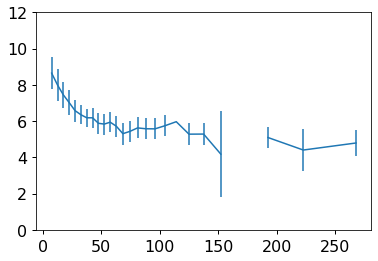

In [24]:
# Random and systematic error in CMLR relations (Roediger & Courteau 2015)
dCMLR = 0.15
dCMLR_sys = 0.3

outer_gmr_corr = np.average(gmr_corr[range_index_corr[0]:range_index_corr[1]], weights=1/(gmr_corr_err[range_index_corr[0]:range_index_corr[1]])**2)
outer_gmr_corr_err = np.sqrt(np.std(gmr_corr[range_index_corr[0]:range_index_corr[1]], ddof=1)**2 + np.mean(gmr_corr_err[range_index_corr[0]:range_index_corr[1]])**2)
outer_gmr_corr_err_sys = np.sqrt(np.std(gmr_corr[range_index_corr[0]:range_index_corr[1]], ddof=1)**2 + np.mean(gmr_corr_err_sys[range_index_corr[0]:range_index_corr[1]])**2)

gmr_corr_fixed = np.array([g if i < range_index_corr[1] else outer_gmr_corr for i,g in enumerate(gmr_corr)])
gmr_corr_fixed_err = np.array([g if i < range_index_corr[1] else outer_gmr_corr_err for i,g in enumerate(gmr_corr_err)])
gmr_corr_fixed_err_sys = np.array([g if i < range_index_corr[1] else outer_gmr_corr_err_sys for i,g in enumerate(gmr_corr_err_sys)])

mass_density_corr_fixed = -0.4*(SB_g_corr - DM)
mass_density_corr_fixed += 2.029*gmr_corr_fixed - 0.984 + 2.044
mass_density_corr_fixed += np.log10(1/(kpc_factor)**2)

dg = 2.5*np.log10(np.e)*flux_g_corr_err/(flux_g - model_flux_g_scattered)
dg_sys = 2.5*np.log10(np.e)*flux_g_corr_syserr/(flux_g - model_flux_g_scattered)

mass_density_corr_fixed_err = np.sqrt((0.4*dg)**2 + (2.029*gmr_corr_fixed_err)**2 + dCMLR**2)
mass_density_corr_fixed_err_sys = np.sqrt((0.4*dg_sys)**2 + (2.029*gmr_corr_fixed_err_sys)**2 + dCMLR**2 + dCMLR_sys**2)

plt.errorbar(radii, mass_density_corr_fixed, yerr=mass_density_corr_fixed_err_sys)
plt.ylim([0,12])

(0.0, 12.0)

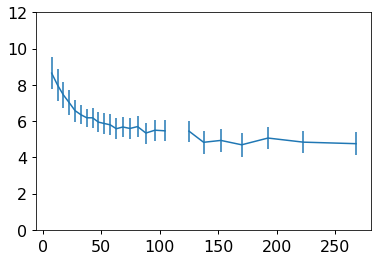

In [25]:
mass_density_corr_fixed2 = -0.4*(SB_r_corr + gmr_corr_fixed - DM)
mass_density_corr_fixed2 += 2.029*gmr_corr_fixed - 0.984 + 2.044
mass_density_corr_fixed2 += np.log10(1/(kpc_factor)**2)

dr = 2.5*np.log10(np.e)*flux_r_corr_err/(flux_r - model_flux_r_scattered)
dr_sys = 2.5*np.log10(np.e)*flux_r_corr_syserr/(flux_r - model_flux_r_scattered)

mass_density_corr_fixed2_err = np.sqrt((0.4*dr)**2 + (2.029*gmr_corr_fixed_err)**2 + dCMLR**2)
mass_density_corr_fixed2_err_sys = np.sqrt((0.4*dr_sys)**2 + (2.029*gmr_corr_fixed_err_sys)**2 + dCMLR**2 + dCMLR_sys**2)

plt.errorbar(radii, mass_density_corr_fixed2, yerr=mass_density_corr_fixed2_err_sys)
plt.ylim([0,12])

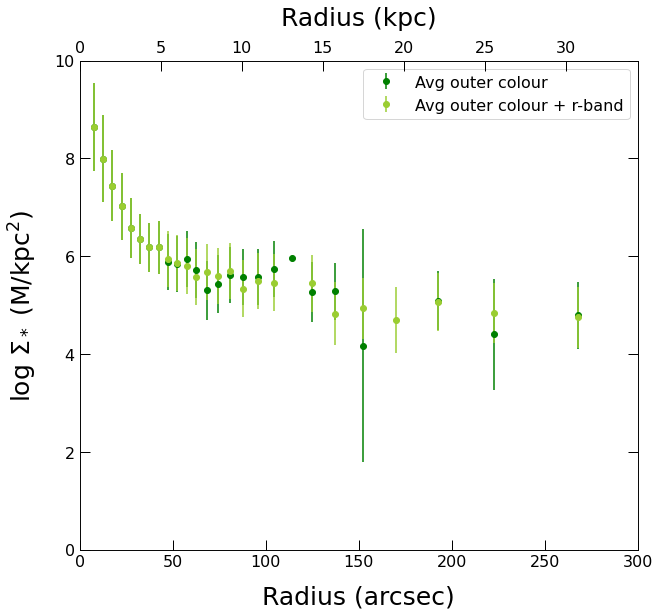

In [26]:
# Plotting all of the surface stellar mass density profiles calculcated above

fig, ax = plt.subplots()

ax.errorbar(radii, mass_density_corr_fixed, yerr=mass_density_corr_fixed_err_sys, fmt='o', c="green", label="Avg outer colour")
ax.errorbar(radii, mass_density_corr_fixed2, yerr=mass_density_corr_fixed2_err_sys, fmt='o', c="yellowgreen", label="Avg outer colour + r-band")

ax.set_ylabel(r"log $\Sigma_*$ (M/kpc$^2$)", size=25, labelpad=15)
ax.set_xlabel(r"Radius (arcsec)", size=25, labelpad=15)

ax.xaxis.set_tick_params(which='major',size=10,pad=5,top=True,right=True)
ax.yaxis.set_tick_params(which='major',size=10,pad=5,top=True,right=True)
ax.tick_params(axis='both',which='major',direction='in')

# Secondary x axis for physical length scales
ax3 = ax.twiny()
ax3.set_xlim(0,kpc_factor*300) 
ax3.set_xlabel(r"Radius (kpc)", size=25, labelpad=15)
ax3.xaxis.set_tick_params(which='major',size=10,pad=5,top=True,right=True, direction="in")

ax.legend(loc=1)

ax.set_xlim(0,300)
ax.set_ylim(0, 10)

fig.set_size_inches(10, 9)
plt.show()

### Fitting surface mass density profile

Some existing work has characterized stellar halos by their power law slope. We fit the outer profile with a power law and use emcee to sample the posterior probability distribution and assess 1-sigma uncertainties for the parameters. (This tutorial was very helpful: https://emcee.readthedocs.io/en/stable/tutorials/line/)

Several different definitions for the beginning of the halo-dominated region can be imagined, and so we perform the fits (and later calculate mass fractions) using four different definitions. These will all be tabulated and will facilitate comparisons with a broad range of work.

In [27]:
def model_exp(theta, x):
    
    a0, h1 = theta    
    model = a0 - x/h1*np.log10(np.e)  
    return model


def model_broken_exp(theta, x):
    
    a0, h1, h2, rbreak = theta
    b0 = a0 + rbreak*(1/h2 - 1/h1)*np.log10(np.e)
    
    model = np.zeros(x.shape)
    model += (x <= rbreak)*(a0 - x/h1*np.log10(np.e))
    model += (x > rbreak)*(b0 - x/h2*np.log10(np.e))   
    return model


def model_powerlaw(theta, x):
    
    a0, k = theta
    return a0 - k*np.log10(x)


def model_disc_halo(theta, x):
    
    a0, h1, b0, k = theta
    return np.log10(np.power(10, a0 - x/h1*np.log10(np.e)) + np.power(10, b0 - k*np.log10(x)))

In [28]:
# Halo fitting indices

halofit_min = next(i for i, r in enumerate(radii) 
                   if (flux_r[i] - model_flux_r_scattered[i]) > 2*model_flux_r_noPSF[i])

# Fitting out to ???
halofit_max = next(i for i, r in enumerate(radii) if r >= 250)

temp_i = [i for i, (val, err) in enumerate(zip(mass_density_corr_fixed2, mass_density_corr_fixed2_err_sys)) if np.isfinite(val) and np.isfinite(err)]
indices_disk = [i for i in temp_i if i >= halofit_min and i <= halofit_max]

x_halo = radii[indices_disk]
y_halo = mass_density_corr_fixed2[indices_disk]
y_err_halo = mass_density_corr_fixed2_err_sys[indices_disk]

In [29]:
def loglike(theta, x, y, yerr):
    
    model = model_powerlaw(theta, x)
    return -0.5*np.sum((y - model)**2/yerr**2)

logl = lambda *args: -loglike(*args)

# Doing the fit!
initial_params = [8.5, 3]

result_halo = minimize(logl, initial_params, args=(x_halo, y_halo, y_err_halo))
mass_density_fitted_halo = model_powerlaw(result_halo.x, radii)
print("Power law fit to halo along minor axis:", result_halo.x)

Power law fit to halo along minor axis: [8.92104904 1.7631815 ]


In [30]:
# Uninformative prior (flat within generous bounds)
def log_prior(theta):
    a0, k = theta
    if 1 < a0 < 20 and 0.1 < k < 10:
        return 0.0
    return -np.inf

def log_prob(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + loglike(theta, x, y, yerr)

pos = result_halo.x + 1e-3 * np.random.randn(32, 2)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(x_halo, y_halo, y_err_halo))
sampler.run_mcmc(pos, 10000)

State([[ 9.40565408  1.94535232]
 [ 9.19861716  1.84406716]
 [ 7.73045386  1.14205061]
 [ 8.12093729  1.33025217]
 [ 8.4879498   1.49217461]
 [ 8.41327905  1.48128724]
 [ 7.84699839  1.35118109]
 [ 9.4723649   2.05144382]
 [ 8.18413067  1.39864023]
 [ 9.8340015   2.28619726]
 [ 7.57024125  0.99016378]
 [ 8.67032138  1.58632083]
 [ 9.58090512  2.04289548]
 [ 9.79705026  2.35863415]
 [ 8.1242124   1.43381662]
 [10.55177326  2.56090869]
 [ 9.23491855  1.8240506 ]
 [ 9.04851181  1.96275934]
 [ 8.83614882  1.66672385]
 [ 9.1504225   1.97319791]
 [ 8.48389031  1.59880219]
 [ 8.98560305  1.79009821]
 [ 9.37952636  2.02189706]
 [ 7.3578822   0.94724654]
 [ 9.40288664  2.01019243]
 [10.01259968  2.33735568]
 [10.45240921  2.52010498]
 [ 8.64947614  1.62937677]
 [10.31900427  2.36629829]
 [ 8.54280568  1.53450102]
 [ 7.26120487  0.91456104]
 [ 9.35040343  1.88030922]], log_prob=[-1.07921123 -0.96469456 -1.20388984 -0.91277647 -0.92052081 -0.72853482
 -2.91212086 -0.69077243 -0.79298423 -1.313747

In [31]:
tau = sampler.get_autocorr_time()
print(tau)

[33.78651945 33.90060829]


In [32]:
flat_samples = sampler.get_chain(discard=100, thin=35, flat=True)
print(len(flat_samples))

9024


In [33]:
# Possible radii limits for stellar halo measurements:

outer_ellip = 0.45

# >5 scale radii (from Imfit model)
halofit_min_0 = next(i for i, r in enumerate(radii) if r >= 21.71*5*(1-outer_ellip))

# >20 kpc
halofit_min_1 = next(i for i, r in enumerate(radii) if r >= 20./kpc_factor)

# Surface mass density < 10^6 M*/kpc^2
halofit_min_2 = next(i for i, s in enumerate(mass_density_corr_fixed) if s <= 6.)

# >5 half-mass radii
# Need to grab half-mass radius from az-avg profiles?
halofit_min_3 = next(i for i, r in enumerate(radii) if r >= 175*(1-outer_ellip))


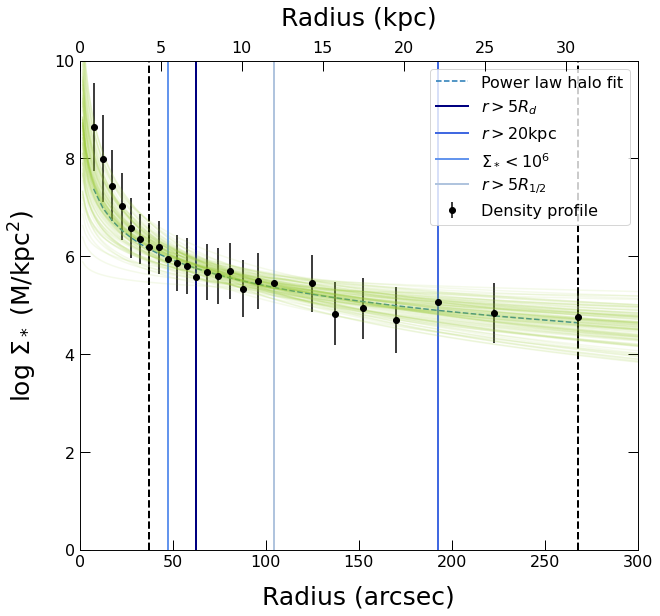

In [34]:
fig, ax = plt.subplots()

# Mass density profile with round(er) outer isophotes
ax.errorbar(radii, mass_density_corr_fixed2, yerr=mass_density_corr_fixed2_err_sys, fmt='o', c="k", label="Density profile")

##plt.plot(radii, mass_density_fitted_disc, '--', label="Exponential disc fit")
plt.plot(radii, mass_density_fitted_halo, '--', label="Power law halo fit")
plt.axvline(x=radii[halofit_min], color='k', linestyle='--', lw=2)
plt.axvline(x=radii[halofit_max], color='k', linestyle='--', lw=2)

plt.axvline(x=radii[halofit_min_0], color='navy', lw=2, label="$r>5R_d$")
plt.axvline(x=radii[halofit_min_1], color='royalblue', lw=2, label="$r>20$kpc")
plt.axvline(x=radii[halofit_min_2], color='cornflowerblue', lw=2, label="$\Sigma_*<10^6$")
plt.axvline(x=radii[halofit_min_3], color='lightsteelblue', lw=2, label="$r>5R_{1/2}$")

inds = np.random.randint(len(flat_samples), size=100)
model_x = np.linspace(0,800,500)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(model_x, model_powerlaw(sample, model_x), color="yellowgreen", alpha=0.1)

ax.set_ylabel(r"log $\Sigma_*$ (M/kpc$^2$)", size=25, labelpad=15)
ax.set_xlabel(r"Radius (arcsec)", size=25, labelpad=15)

ax.xaxis.set_tick_params(which='major',size=10,pad=5,top=True,right=True)
ax.yaxis.set_tick_params(which='major',size=10,pad=5,top=True,right=True)
ax.tick_params(axis='both',which='major',direction='in')

# Secondary x axis for physical length scales
ax3 = ax.twiny()
ax3.set_xlim(0,kpc_factor*300) 
ax3.set_xlabel(r"Radius (kpc)", size=25, labelpad=15)
ax3.xaxis.set_tick_params(which='major',size=10,pad=5,top=True,right=True, direction="in")

ax.legend()

ax.set_xlim(0, 300)
ax.set_ylim(0, 10)

fig.set_size_inches(10, 9)
plt.show()

Best fit for power law slope: 1.763181502789904 +0.5400586882497707/-0.5343738403123643


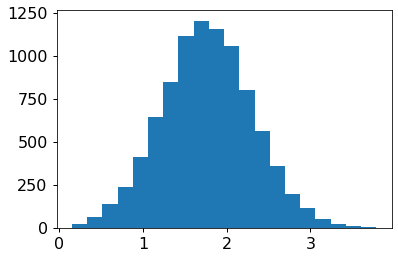

In [35]:
# Uncertainty in fitted power law index k

plt.hist(flat_samples[:,1], bins=20)
err_k_lower, err_k_upper = np.diff(np.percentile(flat_samples[:,1], q=[16, 50, 84]))
print(f"Best fit for power law slope: {result_halo.x[1]} +{err_k_upper}/-{err_k_lower}")

Best fit for power law normalization: 8.921049036495486 +1.0590141040836336/-1.0475701910600277


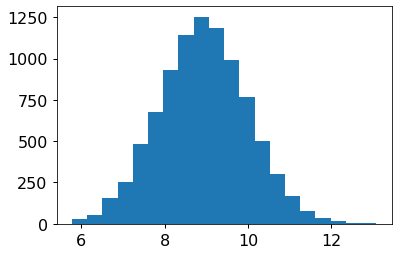

In [36]:
# Uncertainty in fitted power law normalization, just to check

plt.hist(flat_samples[:,0], bins=20)
err_a0_lower, err_a0_upper = np.diff(np.percentile(flat_samples[:,0], q=[16, 50, 84]))
print(f"Best fit for power law normalization: {result_halo.x[0]} +{err_a0_upper}/-{err_a0_lower}")

## Integral of mass density profiles and mass fractions

In [37]:
# Grabbing areas of each radial bin
areas_round = wedge_r.areas  
areas_kpc2 = areas_round*(kpc_factor*pix_size)**2  # Areas assuming round halo
areas_kpc2_e = areas_kpc2/(1 - outer_ellip)        # Areas assuming flattened halo

# Integrating scattered light-corrected profile everywhere 
#M_total, err_M_total_sys = gp.integrate_profile(mass_density_corr_fixed[:halofit_max], areas_kpc2[:halofit_max], mass_density_corr_fixed_err_sys[:halofit_max], 0.7*kpc_factor*pix_size)
M_total, err_M_total_sys = 10.16, 0.20 # S4G
M_total_e, err_M_total_e_sys = gp.integrate_profile(mass_density_corr_fixed2[:halofit_max], areas_kpc2_e[:halofit_max], mass_density_corr_fixed2_err_sys[:halofit_max], 0.7*kpc_factor*pix_size)

print(f"Log total stellar mass: {M_total:.2f} +/- {err_M_total_sys:.2f}")
print(f"Assuming ellipticity of {outer_ellip}: {M_total_e:.2f} +/- {err_M_total_e_sys:.2f}")

Log total stellar mass: 10.16 +/- 0.20
Assuming ellipticity of 0.45: 9.68 +/- 0.50


In [38]:
print("Integrating scattered light-subtracted profile in halo fit regions ...")

M_halo_0c, err_M_halo_0c_sys = gp.integrate_profile(mass_density_corr_fixed2[halofit_min_0:halofit_max], areas_kpc2_e[halofit_min_0:halofit_max], mass_density_corr_fixed2_err_sys[halofit_min_0:halofit_max], 0.7*kpc_factor*pix_size)
f_halo_0c = M_halo_0c - M_total
err_f_halo_0c_sys = np.sqrt(err_M_halo_0c_sys**2 + err_M_total_sys**2)
print(f"Log mass beyond 5 Rd: {M_halo_0c:.2f} +/- {err_M_halo_0c_sys:.2f} (frac: {f_halo_0c:.2f} +/- {err_f_halo_0c_sys:.2f})")

M_halo_1c, err_M_halo_1c_sys = gp.integrate_profile(mass_density_corr_fixed2[halofit_min_1:halofit_max], areas_kpc2_e[halofit_min_1:halofit_max], mass_density_corr_fixed2_err_sys[halofit_min_1:halofit_max], 0.7*kpc_factor*pix_size)
f_halo_1c = M_halo_1c - M_total
err_f_halo_1c_sys = np.sqrt(err_M_halo_1c_sys**2 + err_M_total_sys**2)
print(f"Log mass beyond 20 kpc: {M_halo_1c:.2f} +/- {err_M_halo_1c_sys:.2f} (frac: {f_halo_1c:.2f} +/- {err_f_halo_1c_sys:.2f})")

M_halo_2c, err_M_halo_2c_sys = gp.integrate_profile(mass_density_corr_fixed2[halofit_min_2:halofit_max], areas_kpc2_e[halofit_min_2:halofit_max], mass_density_corr_fixed2_err_sys[halofit_min_2:halofit_max], 0.7*kpc_factor*pix_size)
f_halo_2c = M_halo_2c - M_total
err_f_halo_2c_sys = np.sqrt(err_M_halo_2c_sys**2 + err_M_total_sys**2)
print(f"Log mass below 10^6 M*/kpc^2: {M_halo_2c:.2f} +/- {err_M_halo_2c_sys:.2f} (frac: {f_halo_2c:.2f} +/- {err_f_halo_2c_sys:.2f})")

M_halo_3c, err_M_halo_3c_sys = gp.integrate_profile(mass_density_corr_fixed2[halofit_min_3:halofit_max], areas_kpc2_e[halofit_min_3:halofit_max], mass_density_corr_fixed2_err_sys[halofit_min_3:halofit_max], 0.7*kpc_factor*pix_size)
f_halo_3c = M_halo_3c - M_total
err_f_halo_3c_sys = np.sqrt(err_M_halo_3c_sys**2 + err_M_total_sys**2)
print(f"Log mass beyond 5 Rh: {M_halo_3c:.2f} +/- {err_M_halo_3c_sys:.2f} (frac: {f_halo_3c:.2f} +/- {err_f_halo_3c_sys:.2f})")

Integrating scattered light-subtracted profile in halo fit regions ...
Log mass beyond 5 Rd: 8.71 +/- 0.19 (frac: -1.45 +/- 0.27)
Log mass beyond 20 kpc: 8.22 +/- 0.42 (frac: -1.94 +/- 0.47)
Log mass below 10^6 M*/kpc^2: 8.78 +/- 0.17 (frac: -1.38 +/- 0.26)
Log mass beyond 5 Rh: 8.53 +/- 0.25 (frac: -1.63 +/- 0.32)


## Saving profiles to .csv

In [39]:
np.savetxt(f"NGC{gal}-profiles-minor.csv",
           np.transpose([radii,
            radii*kpc_factor,
            areas_kpc2,
            SB_g_corr,
            SB_g_corr_err_p,
            SB_g_corr_err_m,
            SB_g_corr_err_ps,
            SB_g_corr_err_ms,
            SB_r_corr,
            SB_r_corr_err_p,
            SB_r_corr_err_m,
            SB_r_corr_err_ps,
            SB_r_corr_err_ms,
            gmr_corr_fixed,
            gmr_corr_fixed_err,
            gmr_corr_fixed_err_sys,
            mass_density_corr_fixed2,
            mass_density_corr_fixed2_err,
            mass_density_corr_fixed2_err_sys]),
           fmt='%.5f',
           delimiter=",",
           header="Radius (arcsec),Radius (kpc),Area (kpc^2),m_g,m_g upper err,m_g lower err,m_g upper syserr,m_g lower syserr,m_r,m_r upper err,m_r lower err,m_r upper syserr,m_r lower syserr,g-r,g-r error,g-r error (rand+sys),log Surface mass density (Msun/kpc^2),log Surface mass density error,log Surface mass density error (rand+sys)"
          )

In [40]:
# Also saving masses and mass fractions to a text file
massfile = f"NGC{gal}-masses-fractions-minor.txt"
f = open(massfile, 'w')
f.write("# Halo-dominated region definitions: r>5Rd, r>20kpc, density<10^6, r>5Rh \n")
f.write("# log(Mtot)  err_log(Mtot) log(Mout)  err_log(Mout)  log(f_outer)  err_log(f_outer)\n")
f.write(f"{M_total:.4f}  {err_M_total_sys:.4f}  {M_halo_0c:.4f}  {err_M_halo_0c_sys:.4f}  {f_halo_0c:.4f}  {err_f_halo_0c_sys:.4f}\n")
f.write(f"{M_total:.4f}  {err_M_total_sys:.4f}  {M_halo_1c:.4f}  {err_M_halo_1c_sys:.4f}  {f_halo_1c:.4f}  {err_f_halo_1c_sys:.4f}\n")
f.write(f"{M_total:.4f}  {err_M_total_sys:.4f}  {M_halo_2c:.4f}  {err_M_halo_2c_sys:.4f}  {f_halo_2c:.4f}  {err_f_halo_2c_sys:.4f}\n")
f.write(f"{M_total:.4f}  {err_M_total_sys:.4f}  {M_halo_3c:.4f}  {err_M_halo_3c_sys:.4f}  {f_halo_3c:.4f}  {err_f_halo_3c_sys:.4f}\n")
f.close()